In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
%matplotlib inline
np.random.seed(1)
plt.figure(figsize=(30,30))

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

In [3]:
# Load data
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

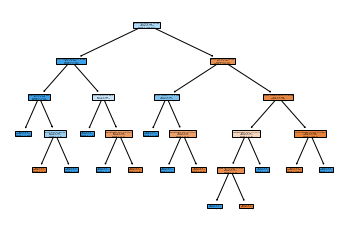

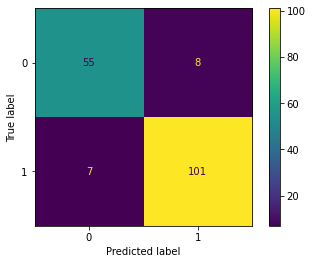

In [4]:
from sklearn.metrics import ConfusionMatrixDisplay

# Apply a decisiontree classifier to the data and visualize your decision tree
# Split the data into training and test set
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.3)

# fit model 
clf = DecisionTreeClassifier(min_samples_leaf=1 , max_depth = None)
clf = clf.fit(trainX, trainy)

# Plot the fitted tree
plot_tree(clf, filled=True, feature_names=cancer.feature_names)
plt.show()

# compute predictions for test set
pred = clf.predict(testX)
# Compute the accuracy score
acc_score = accuracy_score(testy, pred)

# Compute the confusion matrix
conf = confusion_matrix(testy, pred)

# Plot the confusion matrix 
cm_display = ConfusionMatrixDisplay(conf).plot()


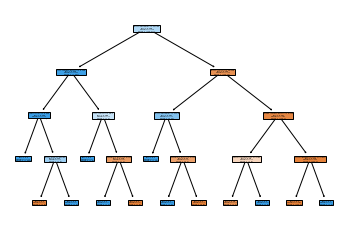

Hyperparameters (best max_depth): {'max_depth': 4}
Training CV Accuracy Score: 0.9423
Test Accuracy Score: 0.9357


In [5]:
# Grid Search - tuning tree depth
from sklearn.model_selection import GridSearchCV

# Define grid for the parameter to test - max_depth from 1 to 10
grid = {'max_depth':np.arange(1,11)}

# Define and fit model
tree = DecisionTreeClassifier()
# Grid search CV with 5-fold cross validation
tree_cv = GridSearchCV(tree, grid, cv=5)
tree_cv.fit(trainX, trainy)

# Plot the fitted tree
plot_tree(tree_cv.best_estimator_, filled=True, feature_names=cancer.feature_names)
plt.show()

# Print results
print("Hyperparameters (best max_depth):", tree_cv.best_params_)
print("Training CV Accuracy Score:", round(tree_cv.best_score_, 4))
print("Test Accuracy Score:", round(tree_cv.score(testX, testy), 4))

Performance measurements 
 training accuracy      :  1.0 
 test accuracy       :  0.953 
 out of bag accuracy :  0.952 



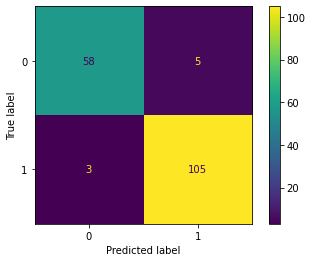

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

# fit model 
clf = RandomForestClassifier(n_estimators=100, oob_score=True)
clf = clf.fit(trainX, trainy)

# compute predictions for the training and test sets
pred_train = clf.predict(trainX)
pred = clf.predict(testX)

# compute the accuracy scores (test, training and OOB)
acc_test = accuracy_score(pred, testy)
acc_train = accuracy_score(pred_train, trainy)
acc_oob = clf.oob_score_

# print the computed scores
print( "Performance measurements", "\n",
       "training accuracy      : ", round(acc_train,3),"\n",
       "test accuracy       : ", round(acc_test,3), "\n",
       "out of bag accuracy : ", round(acc_oob,3),"\n"
       )

# Compute the confusion matrix
conf = confusion_matrix(testy, pred)
# Plot the confusion matrix using a heatmap
cm_display = ConfusionMatrixDisplay(conf).plot()

In [9]:
# Define the grid for the number of trees
grid = {'n_estimators': np.arange(100,1000,100)}

# Do a grid search to find the optimal number of trees
rf = RandomForestClassifier(random_state = 42)
rf_cv = GridSearchCV(rf, grid, cv=5)
rf_cv.fit(trainX, trainy)

# print the best hyperparameter
print("Best Hyperparameter (number of trees):", rf_cv.best_params_)
# print the training CV accuracy score
print("Training CV Accuracy Score:", rf_cv.best_score_)
# print the test accuracy score
print("Test Accuracy Score:", rf_cv.score(testX, testy))

Best Hyperparameter (number of trees): {'n_estimators': 200}
Training CV Accuracy Score: 0.952246835443038
Test Accuracy Score: 0.9590643274853801


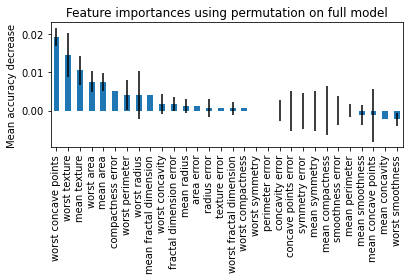

In [15]:
# retrieve the relative importance of each variable and visualize the importance plot
from sklearn.inspection import permutation_importance

# get the best model from the grid search CV
best_rf_model = rf_cv.best_estimator_
# compute the feature importances using permutation test
perm_importances = permutation_importance(
    best_rf_model, testX, testy, n_repeats=10, random_state=42, n_jobs=2)
forest_importances = pd.Series(perm_importances.importances_mean, index=cancer.feature_names)
# sort them
forest_importances.sort_values(inplace=True, ascending=False)

# plot the importances
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=perm_importances.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

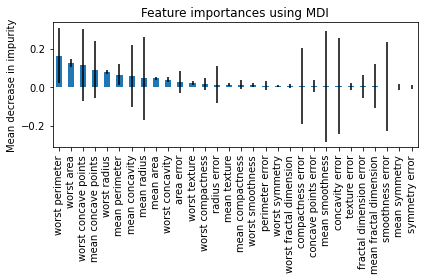

In [16]:
# get the feature importances from the fitted model
importances = best_rf_model.feature_importances_
# get the standard deviations
std = np.std([tree.feature_importances_ for tree in best_rf_model.estimators_], axis=0)
# put them in pandas series
forest_importances = pd.Series(importances, index=cancer.feature_names)
# sort them
forest_importances.sort_values(inplace=True, ascending=False)

# plot them
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()